<img src="./logo_UTN.svg" align="right" width="150" /> 
#### Procesamiento Digital de Señales

# TS10: Filtrado digital lineal de ECG
#### Pablo Romero


# Consigna
Se pide:

c) Diseñe al menos dos filtros FIR y dos IIR para su comparación. Verifique que la respuesta en frecuencia responda a la plantilla de diseño

d) Evalúe el rendimiento de los filtros que haya diseñado:

Verifique que filtra las señales interferentes

Verifique que es inocuo en las zonas donde no hay interferente




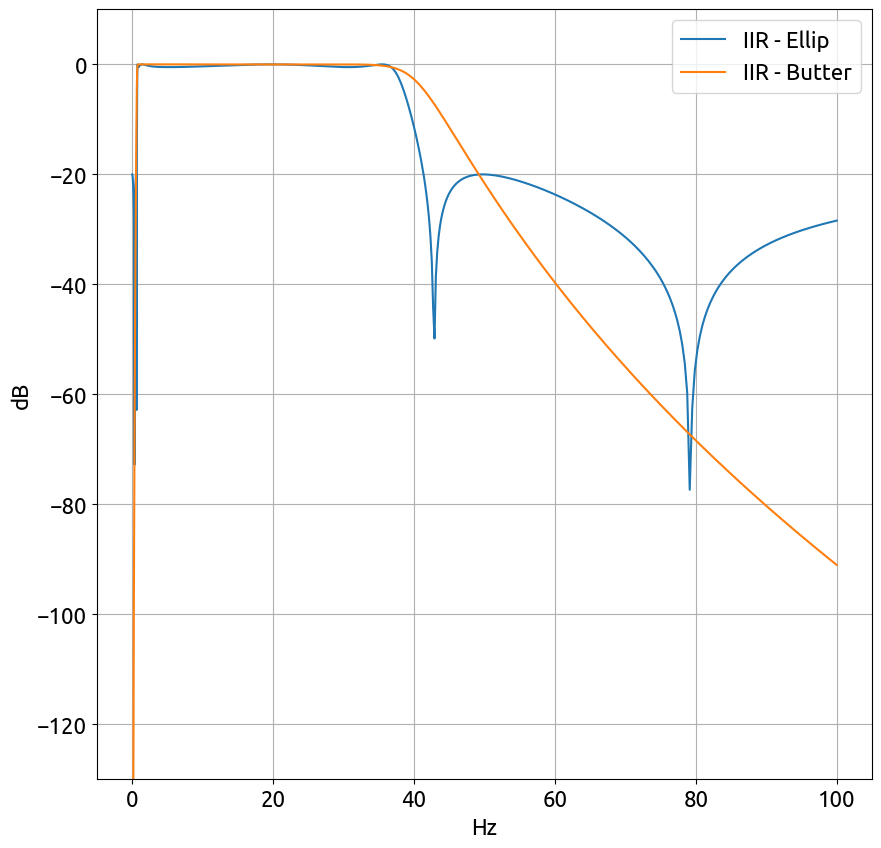

In [7]:
# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib as mpl
#%%  Inicialización de librerías
# Setup inline graphics: Esto lo hacemos para que el tamaño de la salida, 
# sea un poco más adecuada al tamaño del documento
mpl.rcParams['figure.figsize'] = (10,10)

from numpy.fft import fft
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.io as sio


#%% Esto tiene que ver con cuestiones de presentación de los gráficos,
# NO ES IMPORTANTE
fig_sz_x = 14
fig_sz_y = 13
fig_dpi = 80 # dpi

fig_font_family = 'Ubuntu'
fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})
plt.rcParams.update({'font.family':fig_font_family})

##############################################
#%% A partir de aquí comienza lo IMPORTANTE #
#############################################
 
vmax=1       #Amplitud Maxima [Volts]
dc=0            #Valor de continua [Volts]
f0=1 #Frecuencia en [Hz][]
ph=np.pi*1   #Fase [rad]
nn=1000  #Muestras del ADC
fs=1000#Frecuencia de muestreio del ADC [Hz]
k0=nn/4
f0=k0*fs/nn #Frecuencia en [Hz][]         
Ts=1/fs
delta_f=fs/nn
B_bits=4
vf=2
SNRa=25
eps = np.finfo(float).eps
fnyq = 0.5 * fs  # Calculamos frecuencia de Nyquist 

mat_struct = sio.loadmat('ECG_TP4.mat')
ecg_one_lead = mat_struct['ecg_lead']


#Partimos de la plantilla estimada en la TS9

fs0 = 0.25
fc0 = 0.75
fc1 = 36.75
fs1 = 50

alfa_min = 40  # dB
alfa_max= 0.5 # dB

#Implementaremos los filtros ayudandonos de herramientas de diseño que nos aporta la libreria signal
# https://docs.scipy.org/doc/scipy/reference/signal.html


#Inciamos por el IIR

# Definimos bandas de paso y corte (frec. normalizada a Nyquist)
wp = np.array([fc0, fc1]) / fnyq
ws = np.array([fs0, fs1]) / fnyq

# Diseñamos un Butter pasa banda
sos_iir_bp_butter = sig.iirdesign(wp, ws, alfa_max, alfa_min/2, analog=False, ftype='butter', output='sos')


# Diseñamos el Elip pasa banda
sos_iir_bp_ellip = sig.iirdesign(wp, ws, alfa_max, alfa_min/2, analog=False, ftype='ellip',  output='sos')

# Obtenemos las respuestas en frecuencia de los filtros
ff, h_iir_bp_butter       = sig.sosfreqz(sos_iir_bp_butter,       fs=fs,worN=np.logspace(-2,2,2048))
ff, h_iir_bp_ellip        = sig.sosfreqz(sos_iir_bp_ellip,        fs=fs,worN=ff)

#Graficamos la respuesta de los dos filtros IIR y vemos que ambos cumplen las condiciones de diseño

plt.figure(1)
plt.clf()
plt.plot(ff,20*np.log10(np.abs(h_iir_bp_ellip)+eps), label="IIR - Ellip")
plt.plot(ff,20*np.log10(np.abs(h_iir_bp_butter)+eps),label="IIR - Butter")
plt.ylabel("dB")
plt.xlabel("Hz")
plt.ylim(-130,10)
plt.grid()
plt.legend()
plt.show()





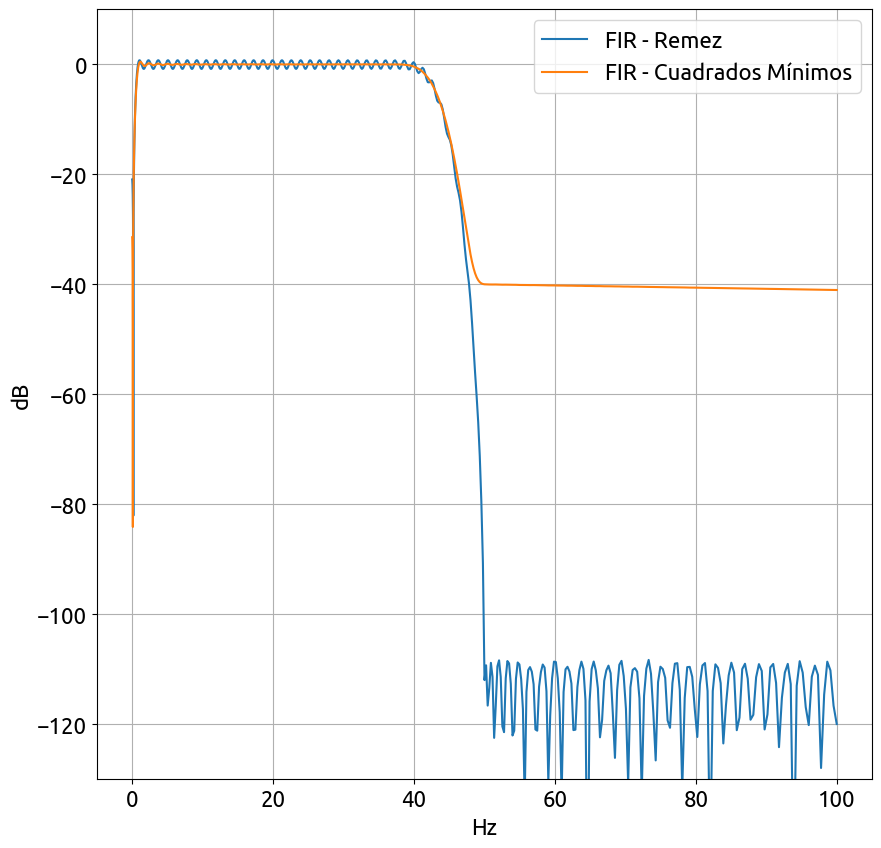

In [8]:
#Inciamos por el FIR

# Diseñamos un filtro remez y filtro por cuadrados minimos (Least Square) pasabanda cascadeando un pasabajos y un pasa alto.

#remez
#Definimos la cantidad de coeficientes del lp y el hp
numtaps_lp = 1501
numtaps_hp = 500

# Definimos bandas de paso y corte
edges_lp = np.array([0, fs0, fc0, fnyq])
edges_hp = np.array([0, fc1, fs1, fnyq])

# Definimos las ganancias en dB y la pasamos a veces
gains_lp = np.array([-200,0])
gains_lp = 10**(gains_lp/20)

gains_hp = np.array([0,-200])
gains_hp = 10**(gains_hp/20)

# Diseñamos el filtro remez
num_lp_remez = sig.remez(numtaps_lp, edges_lp, gains_lp,fs=fs)
num_hp_remez = sig.remez(numtaps_hp, edges_hp, gains_hp,fs=fs)

# cascadeamos el lp y el hp y obtenemo el pasabanda
num_fir_bp_remez = np.polymul(num_lp_remez,num_hp_remez)



#Cuadrados minimos
#Definimos la cantidad de coeficientes del lp y el hp
numtaps_lp = 1501
numtaps_hp = 501

# Definimos bandas de paso y corte
edges_lp = np.array([0, fs0, fc0, fnyq])
edges_hp = np.array([0, fc1, fs1, fnyq])

# Definimos las ganancias en dB y la pasamos a veces
gains_lp = np.array([-200,-(alfa_min),0,0])
gains_lp = 10**(gains_lp/20)

gains_hp = np.array([0, 0, -(alfa_min), -200])
gains_hp = 10**(gains_hp/20)

num_lp_cmin = sig.firls(numtaps_lp, edges_lp, gains_lp,fs=fs)
num_hp_cmin = sig.firls(numtaps_hp, edges_hp, gains_hp,fs=fs)

# cascadeamos el lp y el hp y obtenemo el pasabanda
num_fir_bp_cmin= np.polymul(num_lp_cmin,num_hp_cmin)

# Obtenemos las respuestas en frecuencia de los filtros
ff, h_fir_bp_remez = sig.freqz(num_fir_bp_remez, fs=fs,worN=ff)
ff, h_fir_bp_ls    = sig.freqz(num_fir_bp_cmin, fs=fs,worN=ff)


#Graficamos la respuesta de los dos filtros FIR y vemos que ambos cumplen las condiciones de diseño

plt.figure(2)
plt.clf()
plt.plot(ff,20*np.log10(np.abs(h_fir_bp_remez)+eps), label="FIR - Remez")
plt.plot(ff,20*np.log10(np.abs(h_fir_bp_ls)+eps),label="FIR - Cuadrados Mínimos")
plt.ylabel("dB")
plt.xlabel("Hz")
plt.ylim(-130,10)
plt.grid()
plt.legend()
plt.show()






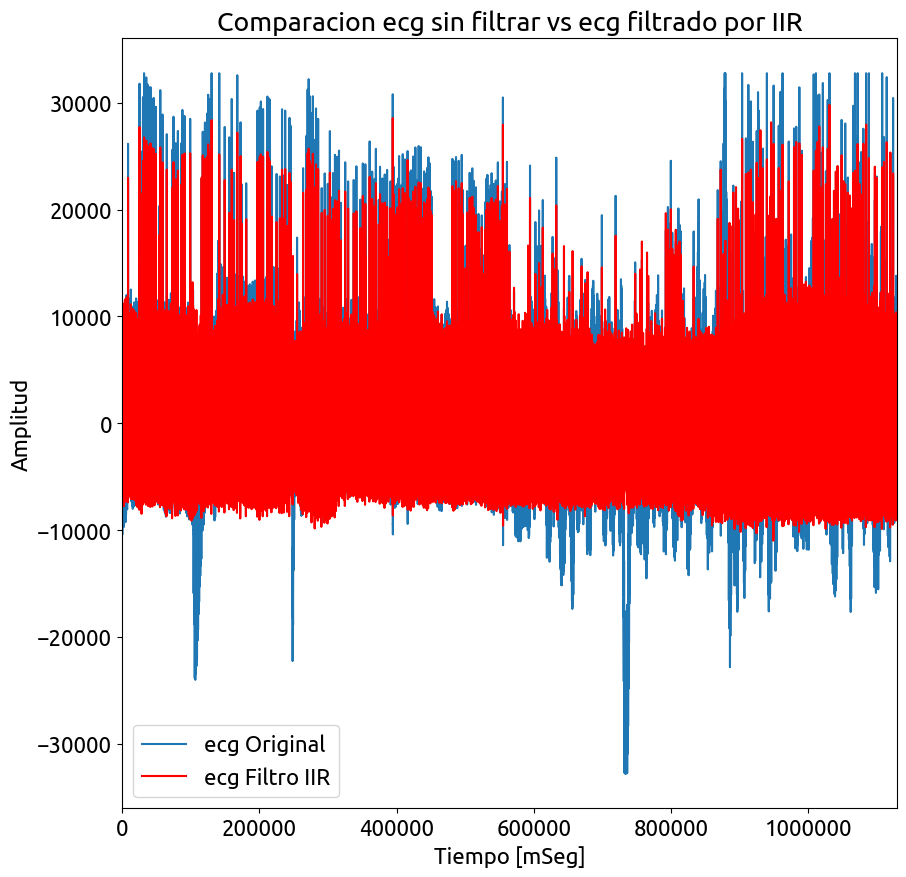

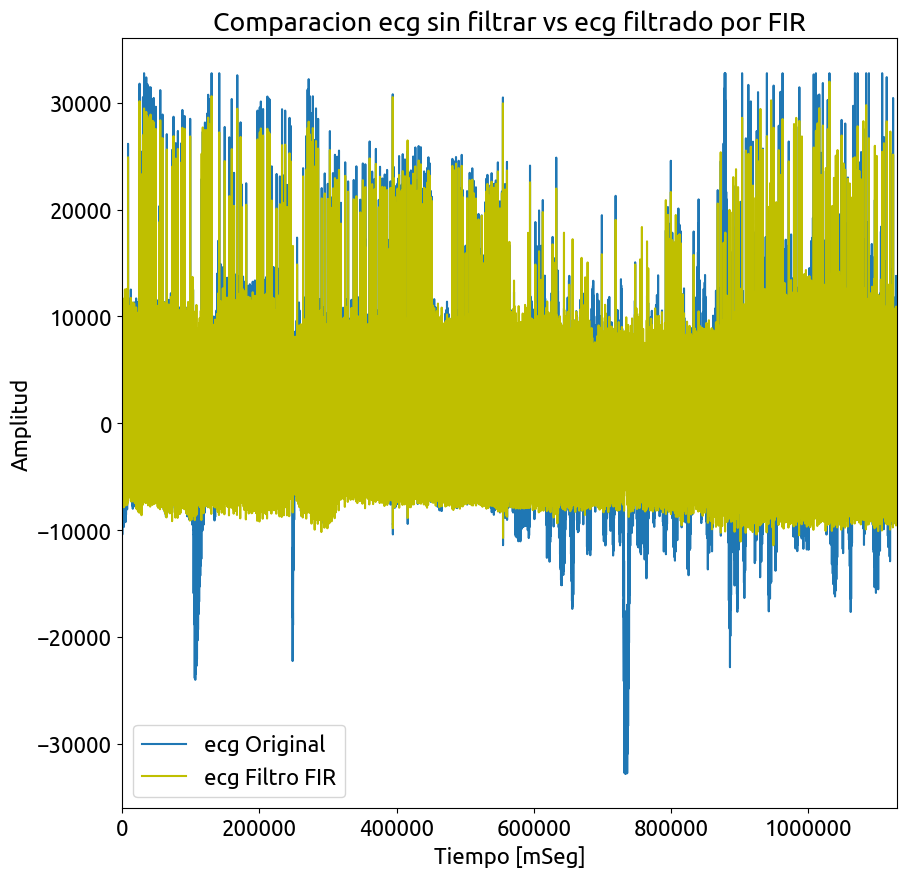

In [9]:
#Acontinuacion aplicaremos el IIR Elip y el FIR cuadrados minimos a la señal ecg y analizaremos los resultados


# Obtenemos las salidas al aplicar los diversos filtros a la señal de entrada y graficamos

ecg_IIR_filt = sig.sosfiltfilt(sos_iir_bp_ellip, ecg_one_lead ,axis=0)

ecg_FIR_filt = sig.filtfilt(num_fir_bp_cmin, 1, ecg_one_lead,axis=0)

plt.figure(3)
plt.clf()
plt.title("Comparacion ecg sin filtrar vs ecg filtrado por IIR")
plt.plot(ecg_one_lead, label = "ecg Original")
plt.plot(ecg_IIR_filt,'r', label = "ecg Filtro IIR")


plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()

plt.figure(4)
plt.clf()
plt.title("Comparacion ecg sin filtrar vs ecg filtrado por FIR")
plt.plot(ecg_one_lead, label = "ecg Original")
plt.plot(ecg_FIR_filt,'y', label = "ecg Filtro FIR")

plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.show()




Vemos que ambos filtros cumplem bien su funcion. A simple vista se puede notar que el filtro IIR atenua un poco mas los picos que el FIR.

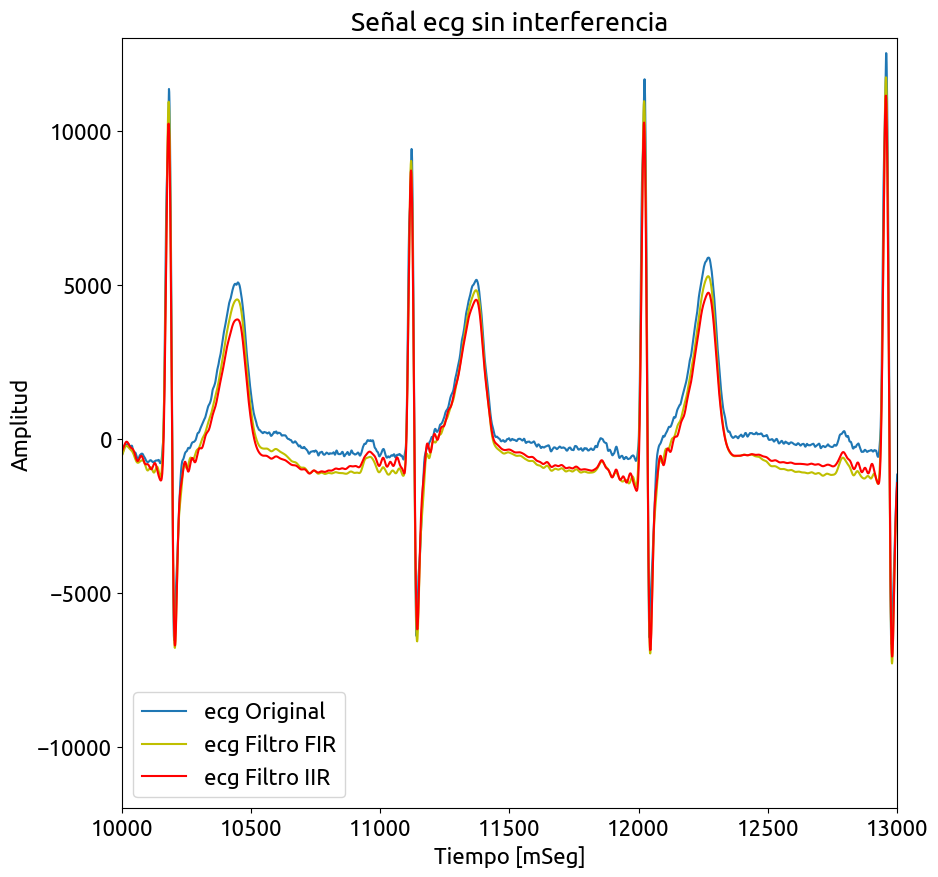

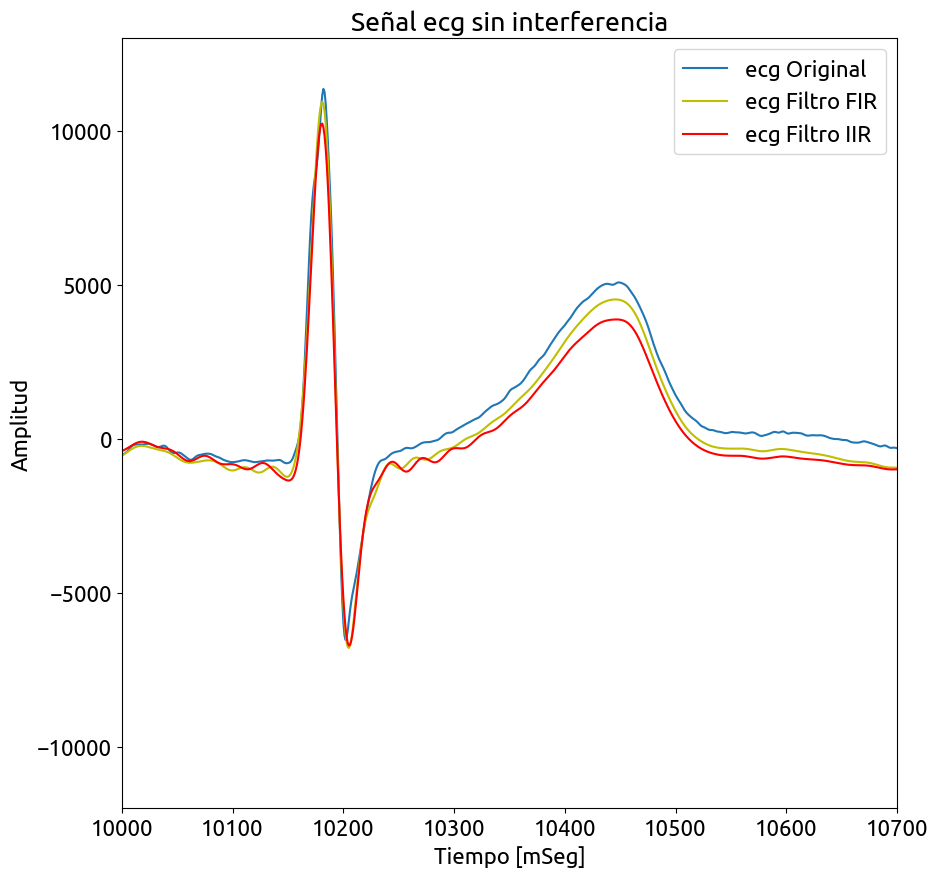

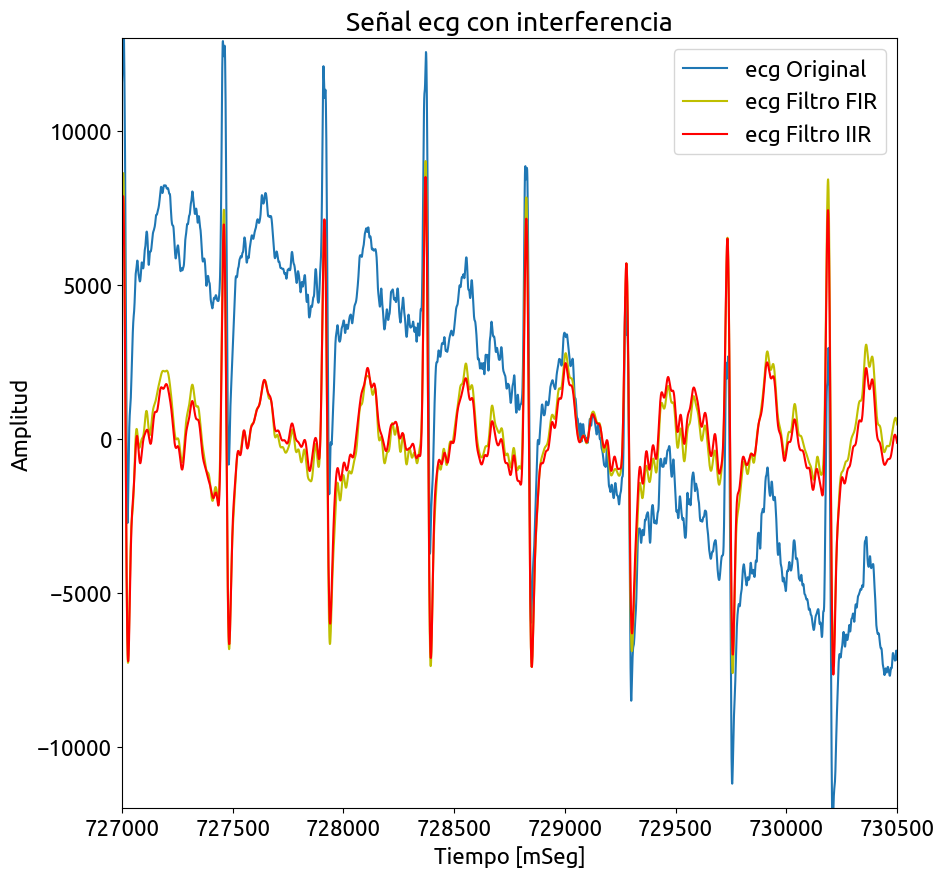

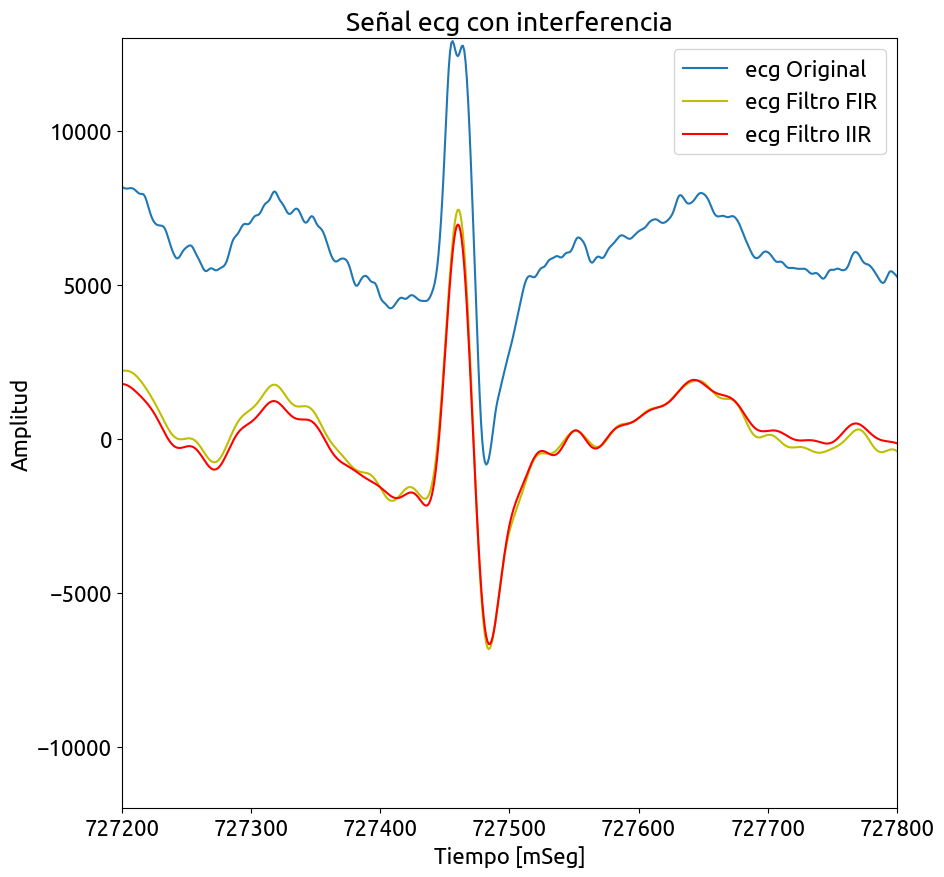

In [10]:
plt.figure(5)
plt.clf()
plt.title("Señal ecg sin interferencia")
plt.plot(ecg_one_lead, label = "ecg Original")
plt.plot(ecg_FIR_filt,'y', label = "ecg Filtro FIR")
plt.plot(ecg_IIR_filt,'r', label = "ecg Filtro IIR")

plt.xlim([10000,13000])
plt.ylim([-12000,13000])

plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
# plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()

plt.figure(6)
plt.clf()
plt.title("Señal ecg sin interferencia")
plt.plot(ecg_one_lead, label = "ecg Original")
plt.plot(ecg_FIR_filt,'y', label = "ecg Filtro FIR")
plt.plot(ecg_IIR_filt,'r', label = "ecg Filtro IIR")

plt.xlim([10000,10700])
plt.ylim([-12000,13000])

plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
# plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()

plt.figure(7)
plt.clf()
plt.title("Señal ecg con interferencia")
plt.plot(ecg_one_lead, label = "ecg Original")
plt.plot(ecg_FIR_filt,'y', label = "ecg Filtro FIR")
plt.plot(ecg_IIR_filt,'r', label = "ecg Filtro IIR")

plt.xlim([727000,730500])
plt.ylim([-12000,13000])

plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
# plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()

plt.figure(8)
plt.clf()
plt.title("Señal ecg con interferencia")
plt.plot(ecg_one_lead, label = "ecg Original")
plt.plot(ecg_FIR_filt,'y', label = "ecg Filtro FIR")
plt.plot(ecg_IIR_filt,'r', label = "ecg Filtro IIR")

plt.xlim([727200,727800])
plt.ylim([-12000,13000])

plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
# plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.show()


Los filtros no modifican la forma de las señales sin interferencia, solo apreciamos cambias en el nivel de continua, lo cual era esperado y que se suaviza el ruido de alta frecuencia. Concluimos que no hay distorcion de en la informacion que se quiere extraer.

En el caso de las señales con interferentes de baja frecuencia el filtro logro eliminar la componente que generaba la deriva del nivel de continua producto de la respiracion del individuo y otros similares.



Fin del documento